In [1]:
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import sys
import os

In [2]:
chemin_data_bass = os.path.abspath('/Users/Ith/code/Lou-SdC/DataBass')
sys.path.append(chemin_data_bass)

In [3]:
filename = '/Users/Ith/code/Lou-SdC/DataBass/raw_data/wav/B51-28100-1111-00521.wav'
y, sr = librosa.load(filename)

In [4]:
y

array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
       -4.7238672e-08,  1.0444569e-07, -1.4446458e-07],
      shape=(44101,), dtype=float32)

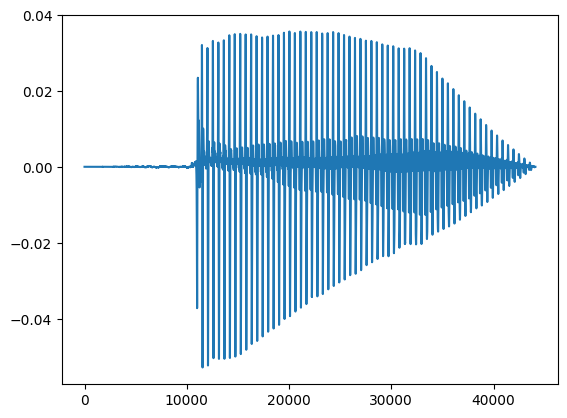

In [5]:
plt.plot(y)

In [7]:
annot_file = 'raw_data/annot/B51-00000-1111-011.xml'


In [6]:
from utils.create_table import create_table

tab = create_table()

Table créée


In [18]:
# Liste des notes de basse 4 cordes (Mi-La-Ré-Sol) sur 24 cases
# Format: (corde, case, note, fréquence)
notes_basse = []

# Fréquences des cordes à vide (standard tuning: E1, A1, D2, G2)
frequences_cordes_vide = {
    'E': 41.20,  # Mi1
    'A': 55.00,  # La1
    'D': 73.42,  # Ré2
    'G': 98.00   # Sol2
}

# Noms des cordes dans l'ordre (de la plus grave à la plus aiguë)
cordes = ['E', 'A', 'D', 'G']

# Générer les notes pour chaque corde (24 cases)
for corde in cordes:
    frequence_vide = frequences_cordes_vide[corde]
    for fret in range(0, 25):  # 0 = corde à vide, 24 = 24ème case
        # Calculer la fréquence pour cette case (fret)
        frequence = frequence_vide * (2 ** (fret / 12))
        # Convertir la fréquence en note (ex: 41.20 Hz → 'E1')
        note = librosa.hz_to_note(frequence)
        notes_basse.append({
            'corde': corde,
            'case': fret,
            'note': note,
            'fréquence (Hz)': round(frequence, 2)
        })

# Créer un DataFrame pandas pour afficher la table
df_notes = pd.DataFrame(notes_basse)

# Sauvegarder dans un fichier CSV
df_notes.to_csv('table_correspondance_notes_basse.csv', index=False)

# Afficher les 10 premières lignes
print("Table de correspondance (notes de basse 4 cordes, 24 cases):")
print(df_notes)

Table de correspondance (notes de basse 4 cordes, 24 cases):
   corde  case note  fréquence (Hz)
0      E     0   E1           41.20
1      E     1   F1           43.65
2      E     2  F♯1           46.25
3      E     3   G1           49.00
4      E     4  G♯1           51.91
..   ...   ...  ...             ...
95     G    20  D♯4          311.13
96     G    21   E4          329.63
97     G    22   F4          349.23
98     G    23  F♯4          370.00
99     G    24   G4          392.00

[100 rows x 4 columns]


In [19]:
def detecter_frequence_fondamentale(y, sr=22050):
    """
    Détecte la fréquence fondamentale d'un signal audio (y) échantillonné à sr Hz.
    Optimisée pour les notes de basse (40-500 Hz).

    Args:
        y (np.ndarray): Signal audio (mono).
        sr (int): Taux d'échantillonnage (par défaut: 22050 Hz).

    Returns:
        float: Fréquence fondamentale détectée (Hz).
    """
    # Calculer le spectrogramme (STFT)
    D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))

    # Récupérer les fréquences associées à chaque bin du spectrogramme
    frequencies = librosa.fft_frequencies(sr=sr)

    # Se limiter à la plage de fréquences de la basse (40-500 Hz)
    freq_mask = (frequencies >= 40) & (frequencies <= 500)
    D_filtered = D[freq_mask, :]
    frequencies_filtered = frequencies[freq_mask]

    # Trouver le pic de fréquence dominant pour chaque frame
    peak_freqs = []
    for frame in D_filtered.T:  # Parcourir chaque frame temporelle
        peak_idx = np.argmax(frame)
        peak_freqs.append(frequencies_filtered[peak_idx])

    # Calculer la fréquence médiane (pour éviter les artefacts)
    frequence_dominante = np.median(peak_freqs)

    return frequence_dominante

In [20]:
# =============================================
# 3. Fonction pour traduire la fréquence en note
# =============================================
def frequence_to_note(frequence, df_notes):
    # Trouver la note la plus proche dans la table
    closest_note = df_notes.iloc[(df_notes['fréquence (Hz)'] - frequence).abs().argsort()[:1]]
    return closest_note['note'].values[0]

In [21]:
 # Étape 2 : Détecter la fréquence fondamentale
frequence = detecter_frequence_fondamentale(y, sr)
print(f"Fréquence détectée : {frequence:.2f} Hz")

# Étape 3 : Traduire en note
note = frequence_to_note(frequence, df_notes)
print(f"Note correspondante : {note}")

Fréquence détectée : 118.43 Hz
Note correspondante : A♯2
